# Final Workflow

Are you sure you want to download the entire dataset? (Y/N)Y


Do you want to set the path:
    C:\Users\joshua.park\Desktop\eeg-wgan\EEGData
as the default EEGBCI dataset path in the mne-python config [y]/n? y


Data downloaded!
Downloaded everything!
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S001\S001R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S001\S001R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S002\S002R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S002\S002R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S003\S003R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S003\S003R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S004\S004R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S004\S004R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S005\S005R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S005\S005R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S006\S006R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S006\S006R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S007\S007R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S007\S007R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S008\S008R01.edf


109
109


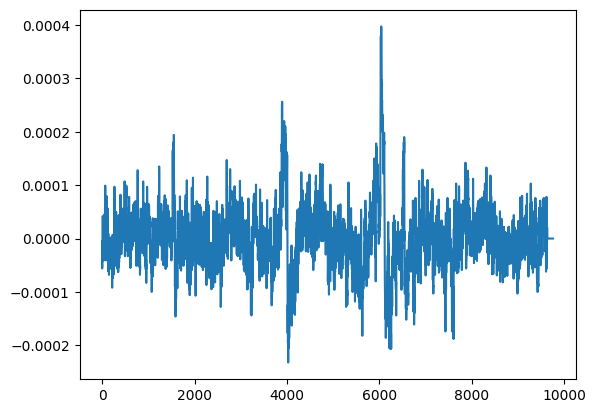

In [1]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

from Data import download_EEGBCI

if input("Are you sure you want to download the entire dataset? (Y/N)") in "Yy":
    total_subjects = list(range(1, 110))
    runs = list(range(1, 15))
    download_EEGBCI(total_subjects, runs, './EEGData', False)
    print("Downloaded everything!")

else:
    print("Download cancelled.")


main_folder = '../EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0'
subdirectories = [f.path for f in os.scandir(main_folder) if f.is_dir()]

opened_files = []
closed_files = []

for subdirectory in subdirectories:
    files = os.listdir(subdirectory)
    
    if len(files) > 0:
        for file in files:
            
            if file[-6:] == '01.edf':
                # This is data for eyes opened
                eyes_opened = os.path.join(subdirectory, file)
                print(eyes_opened)
                opened_files.append(eyes_opened)

            if file[-6:] == '02.edf':
                # This is data for eyes closed
                eyes_closed = os.path.join(subdirectory, file)
                print(eyes_closed)
                closed_files.append(eyes_closed)
    else:
        print(f"No files found in {subdirectory}")
        
        
large_open_data = []
# This is a list of all the data for eyes opened
large_closed_data = []
# This is a list of all the data for eyes closed

for data in opened_files:
    large_open_data.append(mne.io.read_raw_edf(data, preload=True, verbose=False).get_data(verbose=False))

for data in closed_files:
    large_closed_data.append(mne.io.read_raw_edf(data, preload=True, verbose=False).get_data(verbose=False))

# This is the number of files for eyes opened
print(large_open_data.__len__())
# This is the number of files for eyes closed
print(large_closed_data.__len__())


In [4]:
training_data = np.array(large_open_data)
# plt.plot(training_data[0, 0, :])
# plt.show()

print(np.shape(training_data))

plt.figure(figsize=(12, 6))
plt.plot(training_data)
plt.show()




ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (109, 64) + inhomogeneous part.

In [ ]:
# baseline 

NUM_EPOCHS = 200
PRINT_INTERVAL = 10 # every 10 epoch, print status
BATCH_SIZE = 12
NUM_CHANNELS = 64
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

training_data = np.array(large_open_data[0:12])
training_data = torch.tensor(training_data)


def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
            fake = G(noise)
            critic_real = D(real).reshape(-1) # flatten
            critic_fake = D(fake).reshape(-1) # flatten
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            D.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            values = generated_data[0, 0, :]
            plt.plot(values.tolist())
            plt.show()
            
            # plotting G vs D losses
            plt.figure(figsize=(10,5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(gen_err,label="Generator")
            plt.plot(critic_err,label="Critic")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data, disc, gen = train()

torch.save(gen, 'gen.pt')
torch.save(disc, 'disc.pt')

In [ ]:
# baseline with 500 epoch

NUM_EPOCHS = 500
PRINT_INTERVAL = 100 # every 10 epoch, print status
BATCH_SIZE = 12
NUM_CHANNELS = 64
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

training_data = np.array(large_open_data[0:12])
training_data = torch.tensor(training_data)


def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
            fake = G(noise)
            critic_real = D(real).reshape(-1) # flatten
            critic_fake = D(fake).reshape(-1) # flatten
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            D.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            values = generated_data[0, 0, :]
            plt.plot(values.tolist())
            plt.show()
            
            # plotting G vs D losses
            plt.figure(figsize=(10,5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(gen_err,label="Generator")
            plt.plot(critic_err,label="Critic")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data1, disc, gen = train()


In [ ]:
# baseline with deeper gen (+3) and disc (+3)

NUM_EPOCHS = 200
PRINT_INTERVAL = 100 # every 10 epoch, print status
BATCH_SIZE = 12
NUM_CHANNELS = 64
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

training_data = np.array(large_open_data[0:12])
training_data = torch.tensor(training_data)


def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
            fake = G(noise)
            critic_real = D(real).reshape(-1) # flatten
            critic_fake = D(fake).reshape(-1) # flatten
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            D.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            values = generated_data[0, 0, :]
            plt.plot(values.tolist())
            plt.show()
            
            # plotting G vs D losses
            plt.figure(figsize=(10,5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(gen_err,label="Generator")
            plt.plot(critic_err,label="Critic")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data2, disc, gen = train()


In [ ]:
# baseline with clipping values

NUM_EPOCHS = 200
PRINT_INTERVAL = 10 # every 10 epoch, print status
BATCH_SIZE = 12
NUM_CHANNELS = 64
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

training_data = np.array(large_open_data[0:12])
training_data = torch.tensor(training_data)


def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        x = torch.clamp(x, min=-0.3, max=0.3)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
            fake = G(noise)
            critic_real = D(real).reshape(-1) # flatten
            critic_fake = D(fake).reshape(-1) # flatten
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            D.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            values = generated_data[0, 0, :]
            plt.plot(values.tolist())
            plt.show()
            
            # plotting G vs D losses
            plt.figure(figsize=(10,5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(gen_err,label="Generator")
            plt.plot(critic_err,label="Critic")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data3, disc, gen = train()